# 2. házi feladat

A második házi feladat keretében egy mély konvolúciós neuronhálót (CNN) tanítunk be különböző háziállatfajtákról készült képek klasszifikálására a PyTorch könyvtár segítségével. A neuronhálónk alapját egy, az ImageNet adatbázison előtanított mélyháló (a MobileNet 2) adja, melynek architektúráját kisebb átalakításokkal alkalmassá tesszük a feladatunk megoldására, majd finomhangoljuk azt. Mivel nem áll rendelkezésünkre sok címkézett kép háziállatokról, ezért adat-augmentációt is fogunk használni a betanításhoz.

Azért, hogy könnyítsük a hálónk feladatát és csökkentsük a betanítási időt, a képeket nem egy az egyben adjuk be a neuronhálónknak. Helyette, - mivel szegmentációs (pixel szintű) címkék is rendelkezésre állnak a képeinkhez - először azonosítjuk a számunkra fontos objektumok (pl. háziállatok) elhelyezkedését a képeken és az egyes objektumok körül felvett négyzetek segítségével egységes, kisebb méretű képrészleteket vagdosunk ki. Ezek a képrészletek alkotják majd a tanításhoz és kiértékeléshez használt adathalmazunkat.

A házi feladat több részfeladatból áll (A - K), melyek egymásra épülnek. A feladat automatikus tesztelőszkripttel rendelkezik és vizsgálja az egyes részfeladatokra adott megoldások helyességét. Éppen ezért, **ne változtasd meg a notebook struktúráját**, ne szedd több részre, illetve ne módosítsd a megírt részeket, csak a megoldásaidat írd be a megfelelő helyre, különben nem fogjuk tudni értékelni! A megoldások az `# Implement your solution BELOW` és `# Implement your solution ABOVE` sorok közé írandók. Ha a megoldott részfeladatok futtatásakor a "Tester: .... OK" felirat megjelenik, _vélhetően_ jó a megoldás. Azonban, a tesztelőszkript nem képes a megoldások helyességét minden aspektus szerint ellenőrizni, illetve nem is mindegyik részfeladat megoldását ellenőrzi. Emiatt elképzelhető, hogy beadás után további javításokat kérünk a megoldásban. A beadott házi feladatok gépi tanulás alapú plágiumellenőrzésen esnek át. Másolás gyanújának felmerülése esetén mind a másolat(ok), mind az azt/azokat ihlető eredeti megoldások visszautasíthatók.

**!!! A feladatok megoldását, vagy az arra mutató linkeket bárhol közzétenni tilos !!!**

Elakadás esetén javasolt átnézni a Canvason megosztott segédanyag notebookokat és az előadások anyagát. A Canvas fórumon "HF2 GYIK" név alatt, a gyakori kérdéseket és válaszokat gyűjtjük össze. Továbbá, kérhető segítség az oktatóktól is, például a Teams rendszeren keresztül. Ehhez, kérjük a kurzus Canvas oldalán a legfelső modulban található _"
Teams beszélgetés indítása az oktatókkal"_ linket használni: ez egy Teams beszélgetést kezdeményez az összes oktatóval egyidejűleg.

**Megoldás és beküldés menete:**

A közzétett, feladatokat tartalmazó Jupyter notebook a Google Drive-on keresztül lett megosztva, így a Google saját Jupyter notebook szerkesztője és futtatókörnyezete nyílik meg a linkre kattintáskor, a Google Colab. Ennek segítségével online szerkeszthető és futtatható a megosztott notebook. Mivel a notebook csak "view" jogosultságokkal van megosztva, a Google Colab úgynevezett "Playground" módban nyitja azt meg, ahol bár szerkeszthető és futtatható a notebook, de a változtatások nem lesznek automatikusan mentve. A notebook maradandó hatásokkal járó szerkesztése az alábbi módokon lehetséges:
- Ha online szeretnénk a notebookot szerkeszteni és futtatni a Google Colab segítségével, akkor le kell másolni azt a saját Drive tárhelyre (Google Colab file menü -> Save a copy to Drive), majd a másolatot kell megnyitni szerkesztésre.
- A notebook le is tölthető és saját számítógépen is szerkeszthető / futtatható. Ehhez Python környezet megléte szükséges, valamint a notebookban importált Python csomagok és a `jupyterlab`, vagy `notebook` (https://jupyter.org/install) csomag telepítése szükséges a Python disztribúciónk csomagkezelőjével (`pip`, `conda`, WinPython, stb.).

A kész megoldást tartalmazó notebookot (.ipynb) fájlként kell feltölteni a Canvas-ban, a házi feladat beadási felületén.
**Kérjük a notebook szerkezetét nem módosítani és nem szétszedni külön feladatok szerint!**

**Határidő:** 2024. május 14., kedd, 23:59.

**Késve legkésőbb leadható:** 2024. május 20., hétfő, 23:59. - **Ezt követően pótlásra és/vagy javításra nincs lehetőség, ezáltal jegyszerzésre sem. !!!**

**Értékelés:** A házi feladat helyes megoldása és oktatók által történő elfogadása feltétele a jegyszerzésnek. A házi feladat minősége részletesen pontozásra nem kerül, az értékelése kétfokozatú: megfelelt / nem felelt meg. Az első határidőig leadott nagyrészt helyes és nagyrészt teljes ("megfelelt") megoldásért 10 pont jár. Késés esetén ez elveszik.

**Kikötés:** Ahol csak lehet, hatékony, vektorizált megoldásokat várunk. További részletekért lásd: Canvas, HF2 GYIK fórum, "Használhatók-e Python ciklusok?" bejegyzés.

Tesztelő szkript letöltése, importok.

In [110]:
# Download tester

#!rm annbsc24_p1_hw2_tester.py
# !wget https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_tester.py
!powershell Invoke-WebRequest -Uri "https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_tester.py" -OutFile "annbsc24_p1_hw2_tester.py"

import os
import tarfile
import PIL
from PIL import Image
import io
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from annbsc24_p1_hw2_tester import Tester
tester = Tester()


Letöltjük a PASCAL VOC adatbázis egy összecsomagolt részhalmazát. A képeket és a hozzájuk tartozó szegmentációs címkéket tartalmazó fájlok együttes mérete 60 megabájt körüli, néhány másodpercet igénybe vehet a letöltése a futtatókörnyezet tárhelyére. Az alábbi parancs nem tölti le a fájlt, ha az már jelen van a tárhelyen. Előfordul, hogy a tárhelyen elérhetők maradnak a fájlok akkor is, ha a futtatókörnyezetről lekapcsolódunk, de ez nem garantált.

In [3]:
#!wget -nc https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_data.tar
!powershell Invoke-WebRequest -Uri "https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_data.tar" -OutFile "annbsc24_p1_hw2_data.tar"

Az adatbázis beolvasása.

In [111]:
jpg_ims = []
label_ims = []

# unpacking tar content directly into memory and decoding jpg/png images from there to avoid working with many small files on disk
with tarfile.open("annbsc24_p1_hw2_data.tar", "r") as tar:
    tar_members = tar.getmembers()
    tar_jpg_members = [member for member in tar_members if member.name[-4:] == '.jpg']  # list only jpg images, not label images
    for jpg_member in tar_jpg_members:
        filename_noext = os.path.split(jpg_member.name)[-1][:-4]

        # get next jpg image
        file_in_tar = tar.extractfile(jpg_member)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        jpg_ims.append(npy_image)

        # get label image corresponding to the jpg image
        label_member_name = 'PascalVOC_annbsc_data/SegmentationClass/' + filename_noext + '.png'
        file_in_tar = tar.extractfile(label_member_name)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))  # using PIL instead of cv2 as it supports loading palette coded png images as single channel integer arrays
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        label_ims.append(npy_image)

jpg_ims = np.stack(jpg_ims, axis=0)
label_ims = np.stack(label_ims, axis=0)

# removing 'border region' (255) from label images and replacing it with background (0)
label_ims[label_ims == 255] = 0

print("Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes:", jpg_ims.shape, label_ims.shape)


Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes: (2913, 240, 320, 3) (2913, 240, 320)


**Adatbázis:** A feladat során a Pascal VOC adatbázis egy csökkentett felbontású részhalmazával kell dolgozni. Az adatbázisban húsz kategóriába (plusz "háttér") sorolt objektumokról készült képek vannak. A színes képekhez azonos felbontású szegmentációs címke tartozik, mely minden pixelre meghatározza annak szemantikus kategóriáját.

Az (n_images, size_y=240, size_x=320, n_channels=3) alakú, `np.uint8` adattípusú `jpg_ims` tömb tartalamazza a különböző állatokról, emberekről, járművekről és egyéb tárgyakról készült képeket. A `label_ims` tömb az említett képekhez rendelt szegmentációs címkéket tárolja. Ennek alakja (n_images, size_y=240, size_x=320), adattípusa ugyancsak `np.uint8`. Az egy-egy képhez tartozó szegmentációs címke, a színes képekkel megegyező felbontású egycsatornás kép, mely minden egyes pixelre megadja az ahhoz rendelt szemantikus kategóriát egy integer formájában. Az adatbázis húsz fajta objektumot (élőlényt/tárgyat) különböztet meg, ezek 1 és 20 közti egész számokkal vannak reprezentálva. Azok a pixelek, melyek egyik kiemelt objektumtípushoz sem tartoznak, a "háttér" (background) kategóriába soroltak és 0 értéket kapnak a szegmentációs címkén.

###**A**: Képek kirajzolása az adatbázisból

Elsőként belenézünk a letöltött adatbázis tartalmába.
- **Rajzolj ki néhány képet és az azokhoz tartozó szegmentációs címkét** a `jpg_ims` és `label_ims` tömbökből! Figyelj rá, hogy a kirajzolt címkeképeken elkülöníthetőek legyen az objektumok a háttértől!
- **Írd a képek fölé, hogy milyen kategóriájú objektumok találhatók meg rajtuk**, pl. így: "[boat, horse, sheep]"! A kategóriák neveinek listája a következő kódblokkban az `ORIG_CAT_NAMES` változóban található. Hagyd ki a "háttér" (background) kategóriát a felsorolásból, hiszen az szinte mindegyik képen jelen van!

A képen látható kategórák:  ['cat']


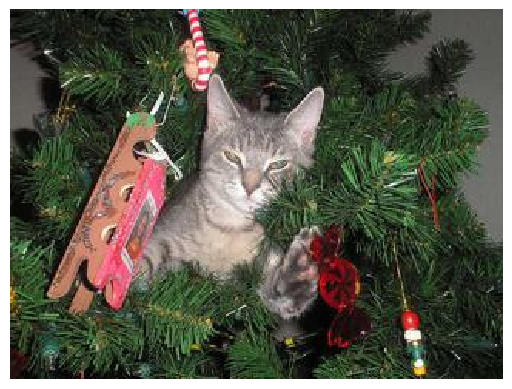

A képen látható kategórák:  ['chair' 'dining table']


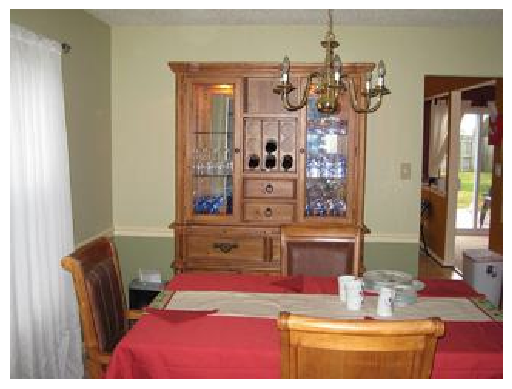

In [112]:
ORIG_CAT_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

# implement your solution BELOW

random_index = 30

cat_nums = np.delete(np.unique(label_ims[random_index]),0,0)
cat_names = np.array(ORIG_CAT_NAMES)

print("A képen látható kategórák: ", cat_names[cat_nums])

plt.imshow(jpg_ims[random_index], interpolation='nearest')
plt.axis('off')
plt.show()

random_index = 100

cat_nums = np.delete(np.unique(label_ims[random_index]),0,0)
cat_names = np.array(ORIG_CAT_NAMES)

print("A képen látható kategórák: ", cat_names[cat_nums])

plt.imshow(jpg_ims[random_index], interpolation='nearest')
plt.axis('off')
plt.show()


###**B**: Új kategóriák definiálása a klasszifikációhoz, releváns képek kiválogatása

Ahogy az előző cellában, a kategórianevek közt láthattuk, öt fajta háziállat szerepel a szegmentációs kategóriák közt. Ezek: 'cat', 'dog', 'cow', 'horse', 'sheep' (macska, kutya, szarvasmarha, ló, birka). Minden más eredeti kategóriabeli képet az 'other' (egyéb) kategóriába sorolunk együttesen. Ebben a feladatban kiválasztjuk a háziállatokat ábrázoló képeket, valamint a fennmaradó, 'other' kategóriájú képekből kiválasztunk még néhányat, hogy háziállatokat nem tartalmazó negatív példákkal is rendelkezzünk a neuronháló betanításához.

Készítsd el a `relevant_idxs` egydimenziós tömböt, mely azoknak a képekeknek az indexeit fogja tárolni a `jpg_ims` és `label_ims` tömbökből, amelyeket felhasználjuk majd a hálónk betanítása során! Kerüljön bele a `relevant_idxs` tömbbe 200 darab véletlenszerűen választott kép indexe azok közül, ahol egy háziállat kategória sem szerepel, majd az összes olyan képnek az indexe, melyen a háziállat kategóriák közül **pontosan egy** szerepel. Rendezd a képeket a tömbben az új kategóriájuk szerinti sorrendbe így: ['other', 'cat', 'dog', 'cow', 'horse', 'sheep'].

Azaz, a `relevant_idxs` tömbben elhelyezett első 200 index olyan képeket indexel a `jpg_ims` és `label_ims` tömbökből, melyeken nincsenek háziállatok, majd ezután következik az összes olyan kép indexe amelyen macskák vannak, de más háziállat nem, majd az összes olyan kép indexe, melyen kutyák vannak, de más háziállat nem és hasonlóan tovább a szarvasmarhákkal, lovakkal, majd végül a birkákkal.

In [113]:
# implement your solution BELOW

#Boti 

animal_categories = np.array([8,10,12,13,17])
all_idxs = np.arange(len(label_ims))

mask = np.any(np.isin(label_ims, animal_categories), axis=(1,2))

animal_idxs = all_idxs[mask]
other_idxs = all_idxs[~mask]

unique_labels = [np.unique(label_ims[index]) for index in animal_idxs]
mask = [len(np.intersect1d(ul,animal_categories)) == 1 for ul in unique_labels]
animal_idxs = animal_idxs[mask]

relevant_idxs = other_idxs[:200] # np.random.choice

list_for_8 = []
list_for_10 = []
list_for_12 = []
list_for_13 = []
list_for_17 = []

for idx in animal_idxs:
    unique_values = np.unique(label_ims[idx])
    if 8 in unique_values:
        list_for_8.append(idx)
    elif 10 in unique_values:
        list_for_10.append(idx)
    elif 12 in unique_values:
        list_for_12.append(idx)
    elif 13 in unique_values:
        list_for_13.append(idx)
    elif 17 in unique_values:
        list_for_17.append(idx)

relevant_idxs = np.concatenate((relevant_idxs, list_for_8,list_for_10,list_for_12,list_for_13,list_for_17))

# implement your solution ABOVE

tester.test('B', relevant_idxs)

Tester: Relevant image indices (Task B) OK


In [39]:
#Miki

np.random.seed(42)

total_images = label_ims.shape[0]
all_indices = np.arange(total_images)
animal_categories = ['cat', 'dog', 'cow', 'horse', 'sheep']
animal_labels = np.array([ORIG_CAT_NAMES.index(i) for i in animal_categories])

mask = np.full((total_images,), True)

animal_labels_array = animal_labels
label_masks = np.any(np.isin(label_ims, animal_labels_array), axis=(1,2))
mask[label_masks] = False

current_indices = all_indices[label_masks]

unique_labels = [np.unique(label_ims[index]) for index in current_indices]
relevant_idxs = current_indices[np.array([len(np.intersect1d(animal_labels, ul)) == 1 for ul in unique_labels])]

non_animal_indices = all_indices[mask]
random_non_animal_indices = np.random.choice(non_animal_indices, size=200, replace=False)

relevant_idxs = np.concatenate((random_non_animal_indices, relevant_idxs))


#print(relevant_idxs[:10])
# implement your solution ABOVE

tester.test('B', relevant_idxs)

Tester: Relevant image indices (Task B) OK


In [94]:
# implement your solution BELOW

np.random.seed(42)

all_idxs = np.arange(label_ims.shape[0])
animal_categories = set([ORIG_CAT_NAMES.index(i) for i in ['cat', 'dog', 'cow', 'horse', 'sheep']])

global_mask = np.full((label_ims.shape[0],), True)

relevant_idxs = np.array([])

for category_index in animal_categories:
  mask = np.any(np.equal(label_ims, category_index), axis=(1,2))
  global_mask[mask] = False
  curr_image_indexes = all_idxs[mask]
  print("Image count for category",category_index,":=", curr_image_indexes.size)
  # only around 200 items to iterate through:
  end_result = []
  for item in curr_image_indexes:
    animalCount = len(animal_categories.intersection(np.unique(label_ims[item])))
    if(animalCount == 1):
      end_result.append(item)
    
  end_result = np.array(end_result)
  relevant_idxs = np.concatenate((relevant_idxs,end_result))
    
relevant_idxs = np.array(relevant_idxs, dtype=np.uint32)

non_animal_idxs = all_idxs[global_mask]
two_hunder_non_animal_idxs = non_animal_idxs[np.random.choice(non_animal_idxs.shape[0], size=200,replace=False)]

relevant_idxs = np.concatenate((two_hunder_non_animal_idxs,relevant_idxs),axis=0)

tester.test('B', relevant_idxs)

Image count for category 8 := 250
Image count for category 10 := 135
Image count for category 12 := 249
Image count for category 13 := 147
Image count for category 17 := 120
Tester: Relevant image indices (Task B) OK


###**C**: Objektum bounding box-ok meghatározása

Azért, hogy könnyítsük a hálónk feladatát és csökkentsük a betanítási időt, a képeket nem egy az egyben adjuk be a neuronhálónknak. Helyette, mivel szegmentációs (pixel szintű) címkék is rendelkezésre állnak a képeinkhez, először azonosítjuk a számunkra fontos objektumok (pl. háziállatok) elhelyezkedését a képeken és az egyes objektumok körül felvett négyzetek segítségével egységes, kisebb méretű képrészleteket vagdosunk ki. Ezek a képrészletek alkotják majd a tanításhoz és kiértékeléshez használt adathalmazunkat.

Ebben a részfeladatban azonosítanod kell a tanításhoz felhasználható objektumok elhelyezkedését, méghozzá azok bounding box-ainak (bennfoglaló téglalapjainak) megadásával. Egy bounding box az a téglalap, mely egy képen található objektumot körülvesz úgy, hogy az objektumhoz tartozó minden pixel a téglalap belsejében, vagy a határoló vonalakon található, a téglalap minden oldalát határoló vonal lefed legalább egy-egy, az objektumhoz rendelt pixelt és a téglalap oldalai párhuzamosak az x vagy y tengelyekkel. Példa az ábrákon:

<img src='https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/bbox.jpg' width='25%'>
<img src='https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/bbox3.png' width='27%'>


A képeken több azonos kategóriájú objektum lehet. Egy objektumot a szegmentációs címkén egy adott értékű összefüggő terület határoz meg. A különböző, összefüggő objektumok elkülönítéséhez segítséget ad a HF2 GYIK fórum.

Készítsd el az `(n_bounding_box, 6)` alakú, integer adattípusú `bboxes` tömböt, mely a `relevant_idxs` által megadott képeken megtalálható objektumokhoz tartalmazza azok bounding box-ának adatait (*)! Minden bounding box-hoz hat értéket tárolunk el. Ezek sorban:
* A téglalap felső oldalának y koordinátája
* A téglalap bal oldalának x koordinátája
* A téglalap alsó oldalának y koordinátája
* A téglalap jobb oldalának x koordinátája
* A tartalmazott objektum (új) kategóriája. Az új kategória az előző feladatban megadott kategóriaindexek, tehát a 0, 1, 2, 3, 4, 5 számok egyike lehet.
* A kapcsolódó kép indexe a `jpg_ims`/`label_ims` tömbökben.

(*) A `bboxes` tömbbe ne kerüljenek bele olyan nem-háziállat objektumok bounding box-ai, melyek háziállatokat tartalmazó képeken vannak! Nem-háziállat objektumok bounding box-ait tehát csak az első 200 képről szedjünk ki, a többi (háziállat kategóriájú) képről pedig csak a háziállatok bounding box-ait gyűjtsük össze! Ezt azért tesszük, hogy ne tévesszük meg a hálónkat ellentmondásos esetekkel: ha a képen háziállat látható, semmiképpen ne kerüljön az "other" kategóriába az.

In [44]:
# implement your solution BELOW
import cv2

animal_categories_list = ['cat', 'dog', 'cow', 'horse', 'sheep']
bboxes = []

first_two_hundred = relevant_idxs[:200].copy()
rest = relevant_idxs[200:].copy()

for i in first_two_hundred:
  image = label_ims[i].copy()
  image[image != 0] = 1
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      temp = np.unique(label_ims[i][y: y + h, x:x + w])
      curr_type = temp[temp != 0][0]
      curr_type = cat_names[curr_type]
      if(curr_type in animal_categories_list):
        bboxes.append([y, x, y + h - 1, x + w - 1,  animal_categories_list.index(curr_type) + 1, i])
      else:
        bboxes.append([y, x, y + h - 1, x + w - 1,  0, i])

for i in rest:
  image = label_ims[i]
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      temp = np.unique(label_ims[i][y: y + h, x:x + w])
      curr_type = temp[temp != 0][0]
      curr_type = cat_names[curr_type]
      if(curr_type in animal_categories_list):
        bboxes.append([y, x, y + h - 1, x + w - 1,  animal_categories_list.index(curr_type) + 1, i])

bboxes = np.array(bboxes)

# implement your solution ABOVE

tester.test('C', bboxes)

ModuleNotFoundError: No module named 'cv2'

In [114]:
#jobb

from skimage.measure import label, regionprops

animal_categories = [8,10,12,13,17]

bboxes = []

for idx in relevant_idxs:
    labeled_image = label(label_ims[idx]) # IMPORTANT labeled_image = label(label_ims[index])
    regions = regionprops(labeled_image)
    for reg in regions:
        minr, minc, maxr, maxc = reg.bbox
        prev_label = label_ims[idx][reg.coords[0][0], reg.coords[0][1]]
        
        if prev_label not in animal_categories:
            bboxes.append([minr, minc, maxr, maxc, 0, idx])
            continue
        
        to_be_label = animal_categories.index(prev_label) + 1
        bboxes.append([minr, minc, maxr, maxc, to_be_label, idx])
        
bboxes = np.array(bboxes)

tester.test('C', bboxes)

# Prepare to display the image and bounding boxes
# fig, ax = plt.subplots(1, figsize=(10, 10))
# ax.imshow(jpg_ims[index], cmap='gray')

# Loop over the regions to draw bounding boxes
# for region in regions:
    # minr, minc, maxr, maxc = region.bbox
    # rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             # edgecolor='red', facecolor='none', linewidth=2)
    # ax.add_patch(rect)

# plt.show()

Tester: Bounding boxes (Task C) OK


###**D**: Képek kirajzolása objektum bounding box-okkal

- Válassz ki véletlenszerűen néhány képet melyekhez tartoznak bounding box-ok (a `bboxes` tömb alapján), rajzold ki ezeket a képeket és rajzold rájuk a hozzájuk tartozó összes bounding box-ot! Rajzold ki **piros színnel** a bounding box téglalapját, ha az egy háziállathoz tartozik és rajzold ki **sárga színnel**, ha az egyéb kategóriájú objektumhoz tartozik!
- Téglalap rajzolásához a matplotlib könyvtárban a `matplotlib.patches.Rectangle` osztály példányosítható, majd ez hozzáadható egy grafikonhoz (Axes-hez) a `matplotlib.axes.Axes.add_patch()` függvénnyel.

_**Megjegyzés**: Ha az előző feladatot jól csináltad, nem kaphatsz olyan képeket itt, melyen sárga és piros téglalapok egyszerre szerepelnek._

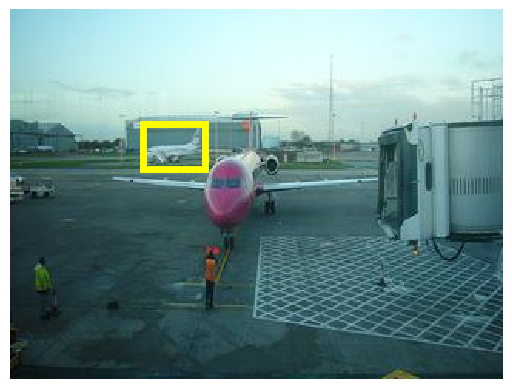

0


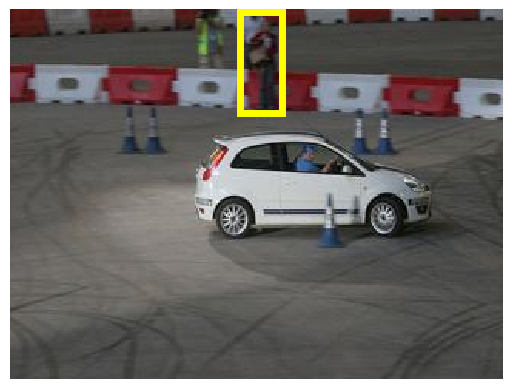

In [115]:
# implement your solution BELOW

random_index = 0

top_left_y, top_left_x, bottom_right_y, bottom_right_x, category, img_idx = bboxes[random_index]
image = jpg_ims[img_idx]

plt.figure()
plt.imshow(jpg_ims[img_idx], interpolation='nearest')
plt.axis('off')

rect_color = "red"
if category <= 0:
    rect_color = "yellow"

rect = plt.Rectangle((top_left_x, top_left_y),  bottom_right_x - top_left_x + 1, bottom_right_y - top_left_y + 1, linewidth=5, edgecolor=rect_color, facecolor='none')

plt.gca().add_patch(rect)

plt.show()

random_index = 1650


top_left_y, top_left_x, bottom_right_y, bottom_right_x, category, img_idx = bboxes[random_index]
image = jpg_ims[img_idx]

plt.figure()
plt.imshow(jpg_ims[img_idx], interpolation='nearest')
plt.axis('off')

rect_color = "red"
print(category)
if category <= 0:
    rect_color = "yellow"

rect = plt.Rectangle((top_left_x, top_left_y),  bottom_right_x - top_left_x + 1, bottom_right_y - top_left_y + 1, linewidth=5, edgecolor=rect_color, facecolor='none')

plt.gca().add_patch(rect)

plt.show()




###**E**: A betanításhoz felhasznált képek és címkék elkészítése

Ebben a feladatban a bounding box-aink környezetéből fogunk négyzet alakú, 160 x 160 pixel felbontású képrészleteket kivágni. Ezek fogják adni majd a neuronhálónk tanító-, validációs- és teszthalmazait. A kivágás módja a következő lesz:

  - A túlzottan kicsi objektumokkal nem foglalkozunk most. Dobd el azokat a bounding box-okat, melyeknek a területe kisebb, mint 1000 pixel!
  - Vedd a megmaradt bounding box-ok középpontjait és vágj ki ugyanezekkel a középpontokkal egy-egy 160 x 160 pixel felbontású négyzetet a képekből!
  - Amennyiben a kivágott kép lelóg az eredeti képről, a lelógó részeket színezd egységesen feketére a kivágott képen, ahogy az az alábbi ábrán is látható:

    <img src='https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_imcrop2.jpg' width='50%'>

A fenti módszerekkel kapott 160 x 160 felbontású képeidet helyezd el az `(n_cropped_images, sy=160, sx=160, n_channels=3)` alakú `xs` tömbbe, ahol `n_cropped_images` az így elkészült kivágott képrészletek számát jelöli! A tömb adattípusa maradjon az eddigi, `uint8`! Készítsd el a tanításhoz felhasználható címkéket tartalmozó tömböt is: legyen `ys` (n_cropped_images,) alakú, integer adattípusú tömb, mely megadja az egyes kivágott képekhez, azok kategóriáját az új hat kategóriás besorolás szerint! Az `ys` tömb elemei, tehát, a 0, 1, 2, 3, 4, 5 értékek lehetnek és sorban az 'other', 'cat', 'dog', 'cow', 'horse', 'sheep' kategóriákat reprezentálják.

In [116]:
# implement your solution BELOW

widths = bboxes[:,3]-bboxes[:,1]
heights = bboxes[:,2]-bboxes[:,0]

mask = widths * heights >= 1000
bboxes = bboxes[mask]

centered_x_coords = bboxes[:,1] + (bboxes[:,3]-bboxes[:,1]) // 2
centered_y_coords = bboxes[:,0] + (bboxes[:,2]-bboxes[:,0]) // 2
image_idxs = bboxes[:,5]

ys = bboxes[:,4]  #categories
xs = []

for i in range(0,len(bboxes)):
  padded_image = np.pad(jpg_ims[image_idxs[i]],((80,80),(80,80),(0,0)), mode='constant')
  x = centered_x_coords[i]
  y = centered_y_coords[i]
  xs.append(padded_image[y:y + 160, x:x + 160])

xs = np.array(xs)

# implement your solution ABOVE

tester.test('E', xs, ys)

Tester: Image cropping & category labels (Task E) OK


###**F**: Keverés és felbontás tanító-, validációs- és teszthalmazra

- Keverjük meg konzisztensen a képeket (`xs`) és a kategóriacímkéket (`ys`). Ez szükséges, hiszen a két tömböt valószínűleg úgy állítottuk elő az előző kódblokkban, hogy a kategóriacímkék sorban következnek egymás után, így a tanító-, validációs- és teszthalmazra való felbontásnál előfordulna olyan kategória, amelyik csak az egyik halamzban lenne jelen. Két tömb azonos sorrendű keveréséhez használható egy közös, véletlenszerűen megkevert indextömb például.
- Bontsuk fel tanító-, validációs- és teszthalmazra a két tömböt! Használjunk 60%/20%/20%-os felosztást! Állítsuk elő így az `xs_train`, `xs_val`, `xs_test` inputokat (képeket) és `ys_train`, `ys_val`, `ys_test` címkéket tartalmazó tömböket!

In [117]:
# implement your solution BELOW

import math

dataset_len = xs.shape[0]
sort_idx = np.arange(dataset_len)
np.random.seed(42)
np.random.shuffle(sort_idx)

train_slice = sort_idx[0:math.floor(dataset_len * 0.6)]
val_slice = sort_idx[math.floor(dataset_len * 0.6):math.floor(dataset_len * 0.8)]
test_slice = sort_idx[math.floor(dataset_len * 0.8):dataset_len]

xs_train = xs[train_slice]
ys_train = ys[train_slice]
xs_val = xs[val_slice]
ys_val = ys[val_slice]
xs_test = xs[test_slice]
ys_test = ys[test_slice]

# implement your solution ABOVE

tester.test('F', xs_train, xs_val, xs_test, ys_train, ys_val, ys_test)

Tester: Dataset split (Task F) OK


###**G**: Az adat-iterátorok létrehozása a képklasszifikációs feladathoz, adat-augmentáció

Az első házi feladathoz és zárthelyihez hasonlóan, ezúttal is iterátorokkal oldjuk meg a neuronhálónk betanítását. Ebben a részfeladatban **elő kell állítanod három iterátor objektumot** `dataloader_train`, `dataloader_val` és `dataloader_test` néven, melyek az előző részfeladatban elkészített tanító-, validációs- és teszthalmazokat tartalmazó input képeket és klasszifikációs címkéket tartalmazó két-két tömböt járják be. **Az iterátorok minden lépésben két tenzort adnak vissza**, melyek egy-egy kötegnyi input képet és az azokhoz tartozó klasszifikációs címkéket tartalmaznak.

A képek esetén szükséges lesz a tengelyek sorrendjének átrendezése, mivel a csatornákat felsoroló tengely eddig hátul volt (_channel-last_ formátum), de a PyTorch erre a tengelyre közvetlenül a kötegméret tengely után számít (_channel-first_ formátum). Ebből kifolyólag, a visszaadott tenzorok alakja `(batch_size, 3, 160, 160)` és `(batch_size,)` lesz. Előbbi a színes képeket tartalmazza változatlan felbontással, utóbbi a képekhez tartozó kategóriaindexeket. `batch_size` a mintaelemek számát adja meg, melyeket egyszerre, egy kötegben fog megkapni a neuronhálónk - ennek értéke lehet például 32.

Hangsúlyozandó, hogy az iterátorok a fent említett NumPy tömbökből (`np.ndarray`) nyert mintaelem-kötegeket már `torch.tensor` típusú objektumokként adják vissza (pontosabban, kételemű tuple-öket adnak vissza, melyekben `torch.tensor` objektumok lesznek). A PyTorch-al definiált neuronhálók betanításához már mindenképp PyTorch tenzorok szükségesek. Az input tenzor **adattípusa** 4 bájtos lebegőpontos típus (`torch.float32`), a kategóriaindexeket tartalmazó tenzor adattípusa pedig, a PyTorch kívánalmait követve, 8 bájtos előjeles egész típus kell, hogy legyen (`torch.int64`)!

A neuronhálónk egy előtanított mély konvolúciós hálón alapul, ezért a képeinket olyan formátumra kell hoznunk, amilyet a háló a betanításakor látott. Az eredetileg [0, 255] intervallumbeli értékeket tartalmazó képeinket először a [0, 1] intervallumra kell leskáláznunk, majd színcsatornánként megadott átlag (`MOBILENET_MEANS`) és szórás (`MOBILENET_STDS`) értékekkel kell sztenderdizálnunk. Az iterátor által visszaadott képek színcsatornánként függetlenül vett átlaga tehát 0 körül, szórása pedig 1 körül lesz a helyes sztenderdizáció után. Ehhez a művelethez útmutatót a "9. előadás, szoftveres rész - PyTorch képklasszifikáció" notebook-ban / videóban találsz, illetve az alábbi linken: https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

Az iterátorok implementációja többféleképpen megoldható, de javasolt a `torch.utils.data` modul `Dataset` és `DataLoader` osztályait felhasználni, vagy szükség esetén származtatni őket.

**Adat-augmentáció:** Sajnos a néhány ezer képből álló adatbázisunkra hamar túltanulna a hálónk és nincs lehetőségünk új tanítóadatot beszerezni, így az adat-augmentálás technikájához kell fordulnunk. Azért, hogy valóban növeljük az adatbázisunkban a képek változatosságát, az adat-augmentációt nem előzetesen alkalmazzuk az egész adatbázison egyben, hanem dinamikusan hajtjuk végre, véletlenszerűen választott transzformációkkal minden újabb mintaelemen, vagy kötegen.

Alkalmazz véletlenszerű adat-augmentációt a **tanító** iterátorban, hogy csökkentsd a túltanulás valószínűségét! Az adat-augmentációs módszerek közt legyen kis méretékű transzláció (eltolás), forgatás, skálázás, illetve a kép színeinek torzítása! A validációs- és teszt-iterátorok ne alkalmazzank adat-augmentációt, hiszen ezeket kiértékeléshez fogjuk használni! Az adat-augmentációhoz javasolt (de nem kötelező) a `torchvision.transforms` modul eszközeit használni. Ennek segítségével a sztenderdizáció is megoldható. A használatára láthatsz példákat a fent említett notebook-ban / videóban és a PyTorch dokumentációjában is.

_**Megjegyzés:** A `torchvision.transforms.Resize` és `torchvision.transforms.CenterCrop` transzformációkra nincs szükség most, hiszen nem akarjuk átméretezni a képeinket már._


In [118]:
MOBILENET_MEANS = [0.485, 0.456, 0.406]
MOBILENET_STDS = [0.229, 0.224, 0.225]   # MobileNet v2 stats used for image normalization

# implement your solution BELOW

class My_Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
      self.images = images
      self.images = torch.tensor(images, dtype=torch.float32)
      self.images = self.images.permute(0,3,1,2) / 255.0
      self.labels = torch.tensor(labels, dtype=torch.int64)
      self.transform = transform

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      label = self.labels[idx]

      if self.transform:
        image = self.transform(image)

      return image, label

mobilnet_mean = [0.485, 0.456, 0.406]
mobilnet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=MOBILENET_MEANS, std=MOBILENET_STDS)
])

eval_transform = transforms.Compose([
    transforms.Normalize(mean=MOBILENET_MEANS, std=MOBILENET_STDS)
])

# Create datasets
train_dataset = My_Dataset(xs_train, ys_train, transform=train_transform)
val_dataset = My_Dataset(xs_val, ys_val, transform=eval_transform)
test_dataset = My_Dataset(xs_test, ys_test, transform=eval_transform)

# Create data loaders
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)



# implement your solution ABOVE

tester.test('G', dataloader_train, dataloader_val, dataloader_test)

Tester: Dataset iterators (Task G) OK


###**H**: A konvolúciós háló definiálása klasszifikációhoz

A konvolúciós hálónk alapját egy, az ImageNet adatbázison előtanított MobileNet v2 neuronháló adja. Ezt alapul véve (és a tanult súlyainak nagyrészét felhasználva) készítjük el a célfeladat megoldására alkalmas konvolúciós hálónkat, amit finomhangolunk az adatbázisunkon.

**Definiáld a (multi-class) klasszifikációs feladathoz alkalmazandó neuronhálót megvalósító osztályt**, mely az általános `torch.nn.Module` osztály leszármazottja!

Töltsd be a MobileNet v2 neuronhálót előtanított súlyokkal, majd ennek utolsó konvolúciós rétegéhez (`features[17].conv[3]`) fűzz hozzá egy kisméretű neuronhálót, melynek architektúrája alkalmas a feladatunk megoldására!

Egy javaslat a hozzáfűzendő rétegekre:
- Egy konvolúciós réteg nem túl nagyszámú (pl. 32) filterrel.
- Két teljesen összekötött réteg, ahol az utolsó neuronjainak számát a feladat határozza meg.
- A rétegek közt aktivációs függvények vannak (pl. ReLU).

**Példányosítsd az új osztályt** és add értékül a `ft_model` nevű változónak a példányt!

Találsz példákat hasonló kódokra a 8. előadásban és a "9. előadás, szoftveres rész - PyTorch képklasszifikáció" notebook-ban / videóban is.

_**Megjegyzés:** Meggyorsíthatja a betanulást, ha a MobileNet hálóhoz tartozó súlyokat befagyasztod (nem tanítod)._


In [119]:
# implement your solution BELOW

class ImageClassificationNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mobilnet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    self.remove_handle = self.mobilnet.features[17].conv[3].register_forward_hook(self.forward_hook)
    self.forward_output = None
    for param in self.mobilnet.parameters():
          param.requires_grad = False

    self.classifier  = torch.nn.Sequential(
        torch.nn.Conv2d(320, 32, kernel_size = (3,3), bias=False),
        torch.nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, 140),
        torch.nn.ReLU(),
        nn.Linear(140, 6),
    )

  def forward_hook(self, module, input, output):
    self.forward_output = output

  def forward(self, x):
    _ = self.mobilnet(x)
    out = self.forward_output
    return self.classifier(out)


ft_model = ImageClassificationNet()


# implement your solution ABOVE

tester.test('H', ft_model)

Tester: Model architecture (Task H) OK


Using cache found in C:\Users\19dar/.cache\torch\hub\pytorch_vision_v0.10.0


###**I**: Néhány augmentált kép kirajzolása

Azért, hogy lássuk, a hálónk megfelelő inputot és címkéket fog kapni, mintavételezünk pár képet és címkét a G) feladatban elkészített iterátorokból és kirajzoljuk ezeket.
- Mintavételezz néhány képet és a hozzájuk tartozó címkéket a `dataloader_train` és `dataloader_val` iterátorokból, majd rajzold ki ezeket a képeket és írd föléjük a hozzájuk tartozó címkét (például "3")! Mivel az iterátorok a képeket normalizálják és megváltoztatják a tengelysorrendet is, a helyes kirajzoláshoz ezeket a transzformációkat vissza kell csinálni a kirajzolás előtt.

_**Megjegyzés:** Itt tudod ellenőrizni, hogy egyrészt az adat-augmentáció helyes-e, másrészt, hogy helyes kategóriacímkék tartoznak-e a képekhez._

dataloader_train:
Label: 0 (Other)


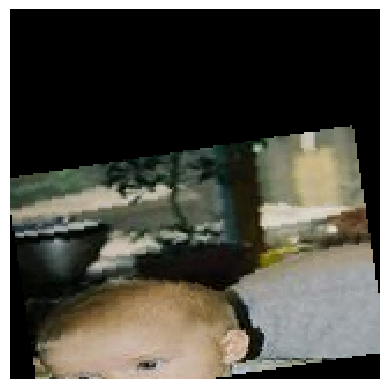

Label: 1 (cat)


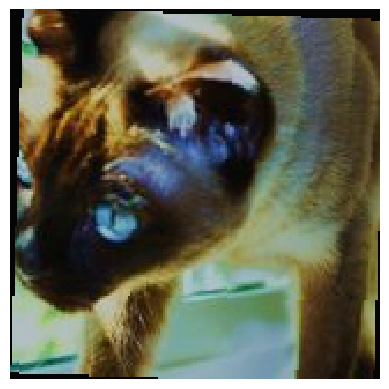

Label: 0 (Other)


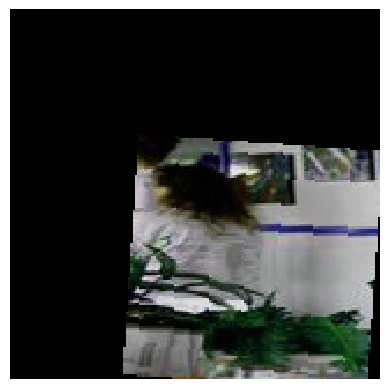

dataloader_val:
Label: 0 (Other)


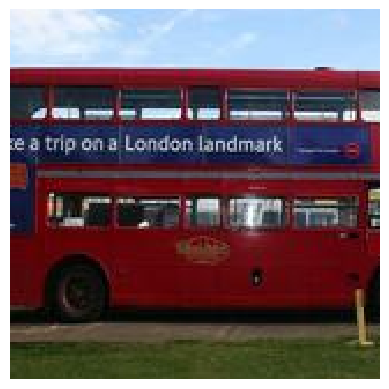

Label: 0 (Other)


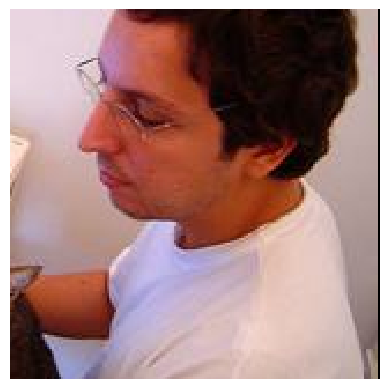

Label: 3 (cow)


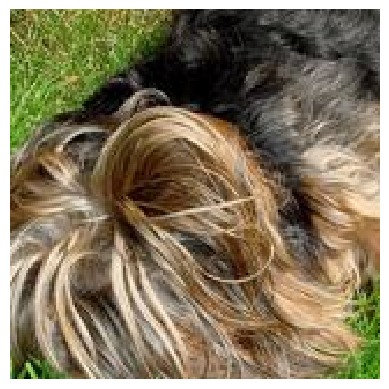

In [123]:
# implement your solution BELOW

animal_categories_list = ['cat', 'dog', 'cow', 'horse', 'sheep']

print("dataloader_train:")
j = 0
for images, classes in dataloader_train:
  if j > 2:
    break

  j += 1

  x = images[0]
  y_hat = classes[0]

  correct_x = x.permute(1,2,0) * torch.tensor(MOBILENET_STDS) + torch.tensor(MOBILENET_MEANS)
  # correct_x *= 255.0 # float => pixels in [0..1]
  y_hat_as_int = int(y_hat)
  if(y_hat_as_int == 0):
    print("Label: 0 (Other)")
  else:
    print("Label:", y_hat_as_int, "("+ animal_categories_list[y_hat_as_int - 1] + ")" )

  plt.figure()
  plt.imshow(correct_x, interpolation='nearest')

  plt.axis('off')
  plt.show()

# -----
print("dataloader_val:")

j = 0
for images, classes in dataloader_val:
  if j > 2:
    break

  j += 1
  #images, classes = next(iter(dataloader_val))

  x = images[0]
  y_hat = classes[0]

  correct_x = x.permute(1,2,0) * torch.tensor(MOBILENET_STDS) + torch.tensor(MOBILENET_MEANS)
  # correct_x *= 255.0 # float => pixels in [0..1]

  y_hat_as_int = int(y_hat)
  if(y_hat_as_int == 0):
    print("Label: 0 (Other)")
  else:
    print("Label:", y_hat_as_int, "("+ animal_categories_list[y_hat_as_int - 1] + ")" )

  plt.figure()
  plt.imshow(correct_x, interpolation='nearest')

  plt.axis('off')
  plt.show()





###**J**: A háló betanítása (multi-class) klasszifikációs feladatra

**Tanítsd be az** `ft_model` **neuronhálót** a tanítóhalmazon a `dataloader_train` iterátor segítségével és alkalmazd a `dataloader_val` iterátort a validációhoz!

Alkalmazd a multi-class klasszifikációkor szokásosan használt **cross-entropy költséget**! **Mérd le minden epoch-ban a tanító- és a validációs halmazon mért költségeket, majd a tanítás végeztével rajzold ki ezeknek az értékeknek a tanítás során való alakulását egy közös grafikonon!** A grafikonon a jelmagyarázat meglétére és a görbék könnyű elkülöníthetőségére figyelj ezúttal is! **Számold ki az _accuracy_ (pontosság) metrikát minden epoch-ban a tanító- és a validációs halmazon** és jelöld ezek alakulását is a grafikonon!

A tanítást az **early stopping** technika állítsa le! Amennyiben adott számú epoch-on keresztül (`patience`) nem javul a validációs költség, érjen véget a betanítás és **állítsuk vissza az `ft_model` súlyait abból az epoch-ból, amikor a legjobb volt a validációs költség!** Mindez automatikusan történjen!

A betanítást követően **számold ki az _accuracy_ metrikát a teszthalmaz elemein is** és add értékül a kapott számot a `test_acc` változónak!! Az _accuracy_ metrika a helyesen klasszifikált mintaelemek arányát adja meg. Például, ha 150 mintaelem kategóriájának becslésekor 75 esetben találtuk el a helyes kategóriát, az _accuracy_ értéke 0.5 lesz.

Using cache found in C:\Users\19dar/.cache\torch\hub\pytorch_vision_v0.10.0


Tranining 1 done, training loss: 1.3038376569747925, validation loss: 1.0386005640029907
Tranining 2 done, training loss: 0.7711082100868225, validation loss: 0.850886344909668
Tranining 3 done, training loss: 0.5976948738098145, validation loss: 0.8807736039161682
Tranining 4 done, training loss: 0.538915753364563, validation loss: 0.9299560189247131
Tranining 5 done, training loss: 0.46332380175590515, validation loss: 0.9231480956077576
Tranining 6 done, training loss: 0.4567660391330719, validation loss: 0.9100398421287537
Tranining 7 done, training loss: 0.38361766934394836, validation loss: 0.9892661571502686
Tranining 8 done, training loss: 0.4322848320007324, validation loss: 0.942572832107544
Tranining 9 done, training loss: 0.37763646245002747, validation loss: 0.9386231899261475
Tranining 10 done, training loss: 0.3342331051826477, validation loss: 1.0474724769592285
Tranining 11 done, training loss: 0.30694979429244995, validation loss: 1.0989855527877808
Tranining 12 done,

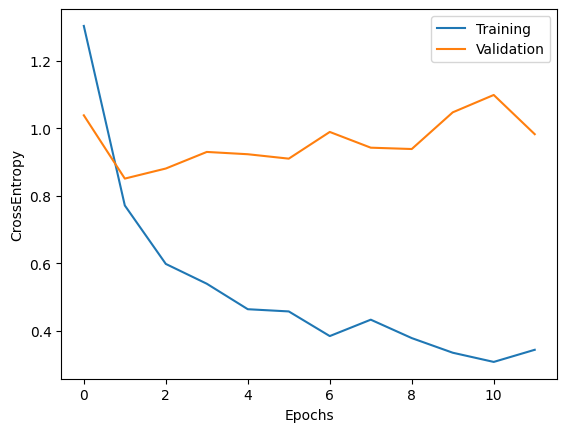

Test accuracy is: 96.18167877197266%
Tester: Model training (Task J) OK


In [125]:
# implement your solution BELOW

model = ImageClassificationNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_loss = np.inf
no_improvement_count = 0
patience = 10
delta=0.01

epoch = 0

while True:
  model.train()
  train_epoch_losses = []

  for x, y in dataloader_train:
    optimizer.zero_grad()
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    train_epoch_losses.append(loss)
    loss.backward()
    optimizer.step()

  train_epoch_losses = torch.tensor(train_epoch_losses)
  avg_epoch_loss = train_epoch_losses.mean()
  train_losses.append(avg_epoch_loss)

  model.eval()
  val_epoch_losses = []

  for x, y in dataloader_val:
    with torch.no_grad():
      y_hat = model(x)

    loss = loss_fn(y_hat, y)
    val_epoch_losses.append(loss)

  val_epoch_losses = torch.tensor(val_epoch_losses)
  avg_epoch_loss = val_epoch_losses.mean()
  val_losses.append(avg_epoch_loss)

  if avg_epoch_loss + delta < best_loss:
    best_loss = avg_epoch_loss
    no_improvement_count = 0
    torch.save(model.state_dict(), 'best_model.pth')
  else:
    no_improvement_count += 1

  print(f'Tranining {epoch+1} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

  if no_improvement_count >= patience:
    print('Stopped by early stopping.')
    print('Best validation loss: ', best_loss.item())
    model.state_dict = torch.load('best_model.pth')
    break

  epoch += 1


# Graph:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy')
plt.legend()
plt.show()

test_losses = []
for x, y in dataloader_test:
  with torch.no_grad():
    y_hat = model(x)

  loss = loss_fn(y_hat, y)
  test_losses.append(loss)

test_acc = torch.mean(torch.tensor(test_losses, dtype=torch.float32))

print("Test accuracy is:", (float(test_acc) * 100).__str__() + "%")

# implement your solution ABOVE

tester.test('J', test_acc)

###**K**: Néhány predikció kirajzolása

Végezetül, mintavételezz pár képet a **teszt iterátorból**, becsülj rájuk címkét a betanított modellel, majd rajzold ki a képeket és írd ki föléjük a becsült és a helyes címkét! Hasonlóan az I) részfeladathoz, itt is figyelned kell a képek helyes megjelenítésére!

Correct Label: 0 (other) | Predicted label: 0 (other)


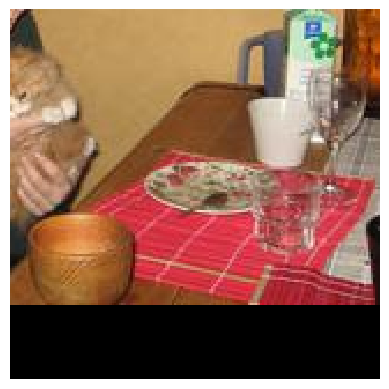

Correct Label: 5 (sheep) | Predicted label: 5 (sheep)


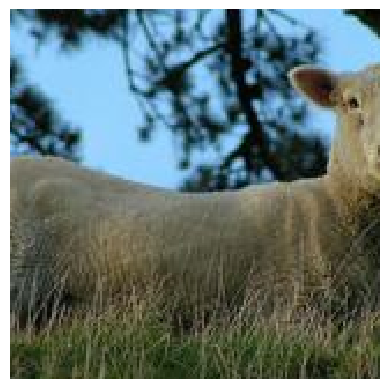

Correct Label: 2 (dog) | Predicted label: 0 (other)


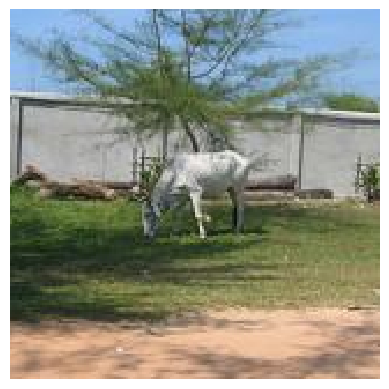

In [126]:
# implement your solution BELOW
import random

random.seed(None)
random_batch_index = random.randint(0,31)

j = 0
for x, y in dataloader_test:
  if j > 2:
    break

  j += 1

  with torch.no_grad():
    y_hat = model(x)

  y_hat = torch.argmax(y_hat[random_batch_index])
  x = x[random_batch_index]
  y = int(y[random_batch_index])
  correct_x = x.permute(1,2,0) * torch.tensor(MOBILENET_STDS) + torch.tensor(MOBILENET_MEANS)
  # correct_x *= 255.0 # float => pixels in [0..1]

  label_for_real = "(other)"
  if (y > 0):
    label_for_real = "("+ animal_categories_list[y - 1] + ")"

  y_hat_as_int = int(y_hat)
  label_for_hat = "(other)"
  if (y_hat_as_int > 0):
    label_for_hat = "("+ animal_categories_list[y_hat_as_int - 1] + ")"

  print("Correct Label:", y, label_for_real, "| Predicted label:", y_hat_as_int, label_for_hat)

  plt.figure()
  plt.imshow(correct_x, interpolation='nearest')

  plt.axis('off')
  plt.show()





